# Core Analysis (Analyse)

## Purpose

This notebook answers the business question:

**What characteristics are most strongly associated with books becoming and remaining Amazon bestsellers, based on price, genre, user ratings, and review volume?**

We focus on:
- Genre performance over time
- Pricing patterns
- Relationship between price, rating, and reviews (popularity proxy)
- Authors/books that repeatedly appear across years (persistence proxy)


In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option("display.max_columns", None)

here = Path.cwd()
repo_root = next((p for p in [here, *here.parents] if (p / "requirements.txt").exists()), None)

if repo_root is None:
    raise FileNotFoundError("Repo root not found (requirements.txt not found in cwd parents).")

print("Working directory:", here)
print("Repo root:", repo_root)


Working directory: /workspaces/london-airbnb-market-expansion/notebooks
Repo root: /workspaces/london-airbnb-market-expansion


In [23]:
clean_path = repo_root / "data_cleaned" / "amazon_books_cleaned.csv"

if not clean_path.exists():
    raise FileNotFoundError(f"Cleaned dataset not found at: {clean_path}")

df = pd.read_csv(clean_path)
display(df.head())

df.shape

df.info()


,name,author,user_rating,reviews,price,year,genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         550 non-null    object 
 1   author       550 non-null    object 
 2   user_rating  550 non-null    float64
 3   reviews      550 non-null    int64  
 4   price        550 non-null    int64  
 5   year         550 non-null    int64  
 6   genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


In [24]:
display(pd.Series(df.columns, name="columns"))

df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["reviews"] = pd.to_numeric(df["reviews"], errors="coerce").astype("Int64")
df["user_rating"] = pd.to_numeric(df["user_rating"], errors="coerce")

df["genre"] = df["genre"].astype(str).str.strip().str.title()
df["name"] = df["name"].astype(str).str.strip()
df["author"] = df["author"].astype(str).str.strip()

display(df.isna().sum().sort_values(ascending=False))


0           name
1         author
2    user_rating
3        reviews
4          price
5           year
6          genre
Name: columns, dtype: object

name           0
author         0
user_rating    0
reviews        0
price          0
year           0
genre          0
dtype: int64

## KPI Definitions

We will use the following KPIs:

- **Price KPI:** median and mean price by year and genre  
- **Quality KPI:** user rating (mean/median)  
- **Popularity KPI:** reviews (median/mean; plus “high-performing segment” share)  
- **Genre KPI:** share of bestsellers by genre and how it changes over time  
- **Persistence proxy:** repeat appearances by book and author across years  


In [25]:
summary = {
    "years_covered": (int(df["year"].min()), int(df["year"].max())),
    "rows": int(df.shape[0]),
    "unique_books": int(df[["name", "author"]].drop_duplicates().shape[0]),
    "unique_authors": int(df["author"].nunique()),
    "genres_count": df["genre"].value_counts().to_dict(),
    "median_price": float(df["price"].median()),
    "median_rating": float(df["user_rating"].median()),
    "median_reviews": float(df["reviews"].median()),
}
summary


{'years_covered': (2009, 2019),
 'rows': 550,
 'unique_books': 351,
 'unique_authors': 248,
 'genres_count': {'Non Fiction': 310, 'Fiction': 240},
 'median_price': 11.0,
 'median_rating': 4.7,
 'median_reviews': 8580.0}

## 1) Genre performance over time


In [26]:
genre_share = (
    df["genre"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .rename("share_pct")
    .reset_index()
    .rename(columns={"index": "genre"})
    .sort_values("share_pct", ascending=False)
)

display(genre_share)


,genre,share_pct
0,Non Fiction,56.4
1,Fiction,43.6


In [27]:
genre_year = (
    df.groupby(["year", "genre"], dropna=False)
      .size()
      .reset_index(name="count")
)

genre_year["share_pct"] = (
    genre_year.groupby("year")["count"]
             .transform(lambda s: (s / s.sum()) * 100)
             .round(1)
)

display(genre_year.sort_values(["year", "share_pct"], ascending=[True, False]).head(20))


,year,genre,count,share_pct
1,2009,Non Fiction,26,52.0
0,2009,Fiction,24,48.0
3,2010,Non Fiction,30,60.0
2,2010,Fiction,20,40.0
5,2011,Non Fiction,29,58.0
4,2011,Fiction,21,42.0
7,2012,Non Fiction,29,58.0
6,2012,Fiction,21,42.0
9,2013,Non Fiction,26,52.0
8,2013,Fiction,24,48.0


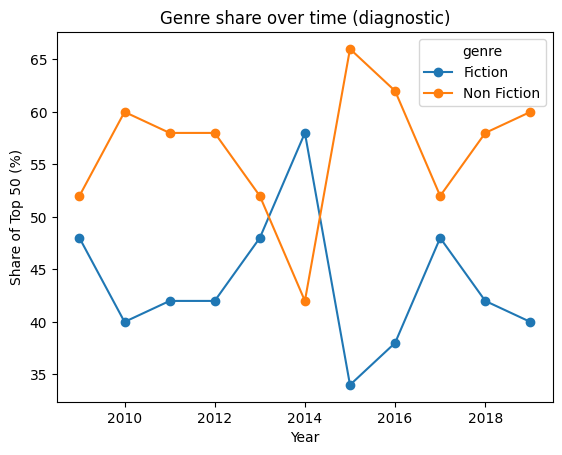

In [28]:
pivot = genre_year.pivot(index="year", columns="genre", values="share_pct").fillna(0)

pivot.plot(kind="line", marker="o")
plt.title("Genre share over time (diagnostic)")
plt.xlabel("Year")
plt.ylabel("Share of Top 50 (%)")
plt.show()


## 2) Pricing patterns


count    550.000000
mean      13.100000
std       10.842262
min        0.000000
25%        7.000000
50%       11.000000
75%       16.000000
max      105.000000
Name: price, dtype: float64

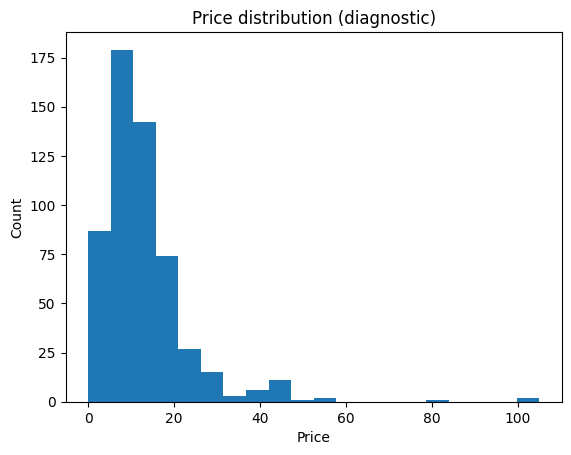

In [29]:
display(df["price"].describe())

plt.hist(df["price"].dropna(), bins=20)
plt.title("Price distribution (diagnostic)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


,count,price_median,price_mean
genre,,,
Non Fiction,310,12.0,14.84
Fiction,240,9.0,10.85


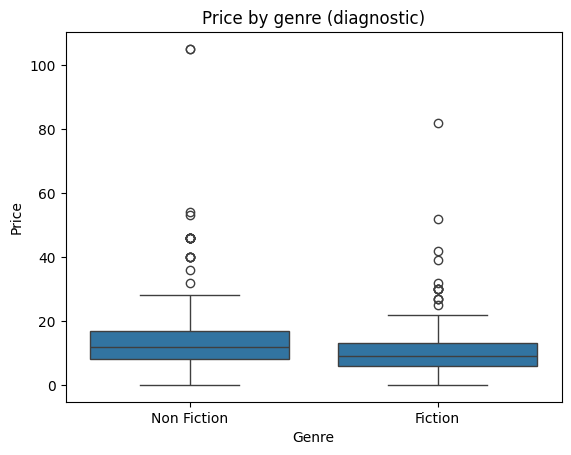

In [30]:
price_by_genre = (
    df.groupby("genre")
      .agg(
          count=("price", "size"),
          price_median=("price", "median"),
          price_mean=("price", "mean")
      )
      .assign(price_mean=lambda x: x["price_mean"].round(2))
      .sort_values("price_median", ascending=False)
)

display(price_by_genre)

sns.boxplot(data=df, x="genre", y="price")
plt.title("Price by genre (diagnostic)")
plt.xlabel("Genre")
plt.ylabel("Price")
plt.show()


## 3) Relationship between price, rating, and reviews


count    550.000000
mean       4.618364
std        0.226980
min        3.300000
25%        4.500000
50%        4.700000
75%        4.800000
max        4.900000
Name: user_rating, dtype: float64

count           550.0
mean     11953.281818
std      11731.132017
min              37.0
25%            4058.0
50%            8580.0
75%          17253.25
max           87841.0
Name: reviews, dtype: Float64

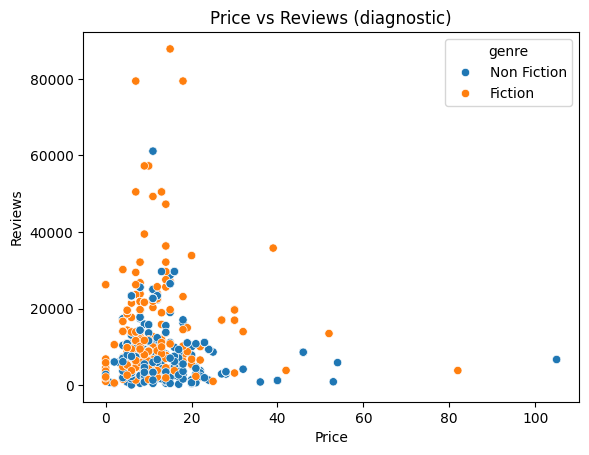

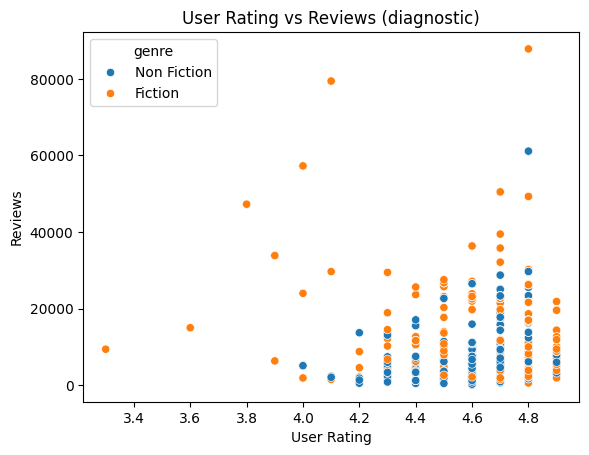

,price,user_rating,reviews
price,1.000,-0.133,-0.109
user_rating,-0.133,1.000,-0.002
reviews,-0.109,-0.002,1.000


In [31]:
display(df["user_rating"].describe())
display(df["reviews"].describe())

sns.scatterplot(data=df, x="price", y="reviews", hue="genre")
plt.title("Price vs Reviews (diagnostic)")
plt.xlabel("Price")
plt.ylabel("Reviews")
plt.show()

sns.scatterplot(data=df, x="user_rating", y="reviews", hue="genre")
plt.title("User Rating vs Reviews (diagnostic)")
plt.xlabel("User Rating")
plt.ylabel("Reviews")
plt.show()

corr = df[["price", "user_rating", "reviews"]].corr(numeric_only=True).round(3)
corr


## 4) High-performing segment (business-friendly lens)

Define “high-performing” as:
- Reviews ≥ median reviews (popularity proxy)
- User rating ≥ median rating (quality proxy)

This is a segmentation lens, not a causal claim.


In [32]:
reviews_median = df["reviews"].median()
rating_median = df["user_rating"].median()

df_seg = df.copy()
df_seg["high_reviews"] = df_seg["reviews"] >= reviews_median
df_seg["high_rating"] = df_seg["user_rating"] >= rating_median
df_seg["high_perf_segment"] = df_seg["high_reviews"] & df_seg["high_rating"]

segment_summary = (
    df_seg.groupby("high_perf_segment")
          .agg(
              count=("name", "size"),
              price_median=("price", "median"),
              rating_median=("user_rating", "median"),
              reviews_median=("reviews", "median")
          )
)

display(segment_summary)


,count,price_median,rating_median,reviews_median
high_perf_segment,,,,
False,379,12.0,4.6,5470.0
True,171,8.0,4.8,17739.0


In [33]:
segment_genre = (
    df_seg.groupby(["genre", "high_perf_segment"])
          .size()
          .reset_index(name="count")
)

segment_genre["share_within_genre_pct"] = (
    segment_genre.groupby("genre")["count"]
                 .transform(lambda s: (s / s.sum()) * 100)
                 .round(1)
)

display(
    segment_genre.sort_values(
        ["high_perf_segment", "share_within_genre_pct"],
        ascending=[False, False]
    ).head(20)
)


,genre,high_perf_segment,count,share_within_genre_pct
1,Fiction,True,97,40.4
3,Non Fiction,True,74,23.9
2,Non Fiction,False,236,76.1
0,Fiction,False,143,59.6


## 5) Persistence proxy: repeat appearances by book and author


In [34]:
book_year = df[["name", "author", "year", "genre", "price", "user_rating", "reviews"]].drop_duplicates()

book_repeats = (
    book_year.groupby(["name", "author"])
             .agg(
                 appearances=("year", "nunique"),
                 first_year=("year", "min"),
                 last_year=("year", "max"),
                 avg_rating=("user_rating", "mean"),
                 avg_reviews=("reviews", "mean"),
                 median_price=("price", "median"),
             )
             .assign(
                 avg_rating=lambda x: x["avg_rating"].round(3),
                 avg_reviews=lambda x: x["avg_reviews"].round(0)
             )
             .sort_values(["appearances", "avg_reviews"], ascending=[False, False])
)

display(book_repeats.head(15))


,,appearances,first_year,last_year,avg_rating,avg_reviews,median_price
name,author,,,,,,
"Publication Manual of the American Psychological Association, 6th Edition",American Psychological Association,10,2009,2018,4.500,8580.0,46.0
StrengthsFinder 2.0,Gallup,9,2009,2017,4.000,5069.0,17.0
"Oh, the Places You'll Go!",Dr. Seuss,8,2012,2019,4.900,21834.0,8.0
The Very Hungry Caterpillar,Eric Carle,7,2013,2019,4.900,19546.0,5.0
The 7 Habits of Highly Effective People: Powerful Lessons in Personal Change,Stephen R. Covey,7,2009,2017,4.643,7354.0,24.0
The Four Agreements: A Practical Guide to Personal Freedom (A Toltec Wisdom Book),Don Miguel Ruiz,6,2013,2019,4.700,23308.0,6.0
Jesus Calling: Enjoying Peace in His Presence (with Scripture References),Sarah Young,6,2011,2016,4.900,19576.0,8.0
To Kill a Mockingbird,Harper Lee,5,2013,2019,4.800,26234.0,0.0
The 5 Love Languages: The Secret to Love that Lasts,Gary Chapman,5,2015,2019,4.800,25554.0,8.0


In [35]:
author_repeats = (
    book_year.groupby("author")
             .agg(
                 unique_titles=("name", "nunique"),
                 total_appearances=("year", "size"),
                 years_active=("year", "nunique"),
                 avg_rating=("user_rating", "mean"),
                 avg_reviews=("reviews", "mean"),
                 median_price=("price", "median"),
             )
             .assign(
                 avg_rating=lambda x: x["avg_rating"].round(3),
                 avg_reviews=lambda x: x["avg_reviews"].round(0)
             )
             .sort_values(["years_active", "total_appearances"], ascending=[False, False])
)

display(author_repeats.head(15))


,unique_titles,total_appearances,years_active,avg_rating,avg_reviews,median_price
author,,,,,,
Jeff Kinney,12,12,11,4.800,5624.0,8.0
Gary Chapman,3,11,11,4.736,13269.0,9.0
American Psychological Association,1,10,10,4.500,8580.0,46.0
Gallup,1,9,9,4.000,5069.0,17.0
Dr. Seuss,2,9,8,4.878,19616.0,8.0
Eric Carle,1,7,7,4.900,19546.0,5.0
Stephen R. Covey,1,7,7,4.643,7354.0,24.0
Rick Riordan,10,11,6,4.773,4015.0,10.0
Bill O'Reilly,6,7,6,4.643,9112.0,10.0


## Interim Findings (to be refined after visuals)

In Notebook 04 we will produce report-ready charts based on:
- Genre share trends over time
- Price differences by genre
- Reviews vs rating relationship (popularity vs satisfaction)
- Repeat authors/books as a persistence signal

Final recommendations will be written in Notebook 05.
